In [1]:
# general tools
import numpy as np
from numpy import random
import scipy as sp

# tree/simulation
from prosstt import simulation as sim
from prosstt import tree
from prosstt import count_model as cm
from prosstt import sim_utils as sut

# dimensionality reduction and visualization
import anndata as ad
from scanpy.api.tl import diffmap
import matplotlib.pyplot as plt

# make sure to use viridis as the default color map
import matplotlib as mpl
mpl.rcParams['image.cmap'] = 'viridis'

/home/npapado/miniconda2/envs/py36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# set random seed
rseed = 45
random.seed(rseed)

make a tree with (almost) default parameters and define sample time and base gene expression values

In [3]:
newick_string = "(B,C)A;"

t = tree.Tree.from_newick(newick_string, genes=500)
sample_time = np.arange(0, t.get_max_time())

Tree topology | Pseudotime in tree
- | -
<img src="tree.png" alt="topology" style="width: 300px;"/> | <img src="pseudotime.png" alt="pseudotime" style="width: 300px;"/>

simulate average gene expression over the tree

In [4]:
uMs, Ws, Hs = sim.simulate_lineage(t, a=0.05, intra_branch_tol=0)
gene_scale = sut.simulate_base_gene_exp(t, uMs)
t.add_genes(uMs, gene_scale)

/home/npapado/miniconda2/envs/py36/lib/python3.6/site-packages/scipy/stats/stats.py:3003: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den


set variance hyperparameters at three levels and observe how the tree reconstruction changes

values in normal range

In [5]:
alpha1 = np.exp(random.normal(loc=np.log(0.2), scale=np.log(1.5), size=t.G))
beta1 = np.exp(random.normal(loc=np.log(1), scale=np.log(1.5), size=t.G)) + 1

X1, labs1, brns1, scalings1 = sim.sample_whole_tree(t, 1, alpha=alpha1, beta=beta1)

# normalize gene expression by library size
X1 = (X1.transpose() / scalings1).transpose()

higher average values, same variance

In [6]:
alpha2 = np.exp(random.normal(loc=np.log(1.2), scale=np.log(1.5), size=t.G))
beta2 = np.exp(random.normal(loc=np.log(2), scale=np.log(1.5), size=t.G)) + 1

X2, labs2, brns2, scalings2 = sim.sample_whole_tree(t, 1, alpha=alpha2, beta=beta2)

# normalize gene expression by library size
X2 = (X2.transpose() / scalings2).transpose()

higher variance for same range

In [7]:
alpha3 = np.exp(random.normal(loc=np.log(0.2), scale=np.log(5), size=t.G))
beta3 = np.exp(random.normal(loc=np.log(1), scale=np.log(5), size=t.G)) + 1

X3, labs3, brns3, scalings3 = sim.sample_whole_tree(t, 1, alpha=alpha3, beta=beta3)

# normalize gene expression by library size
X3 = (X3.transpose() / scalings3).transpose()

perform dimensionality reduction and plot to see the differences

In [8]:
data1 = ad.AnnData(X1)
diffmap(adata=data1)
dm1 = data1.obsm["X_diffmap"]
br_names1, indices1 = np.unique(brns1, return_inverse=True)

data2 = ad.AnnData(X2)
diffmap(adata=data2)
dm2 = data2.obsm["X_diffmap"]
br_names2, indices2 = np.unique(brns2, return_inverse=True)

data3 = ad.AnnData(X3)
diffmap(adata=data3)
dm3 = data3.obsm["X_diffmap"]
br_names3, indices3 = np.unique(brns3, return_inverse=True)

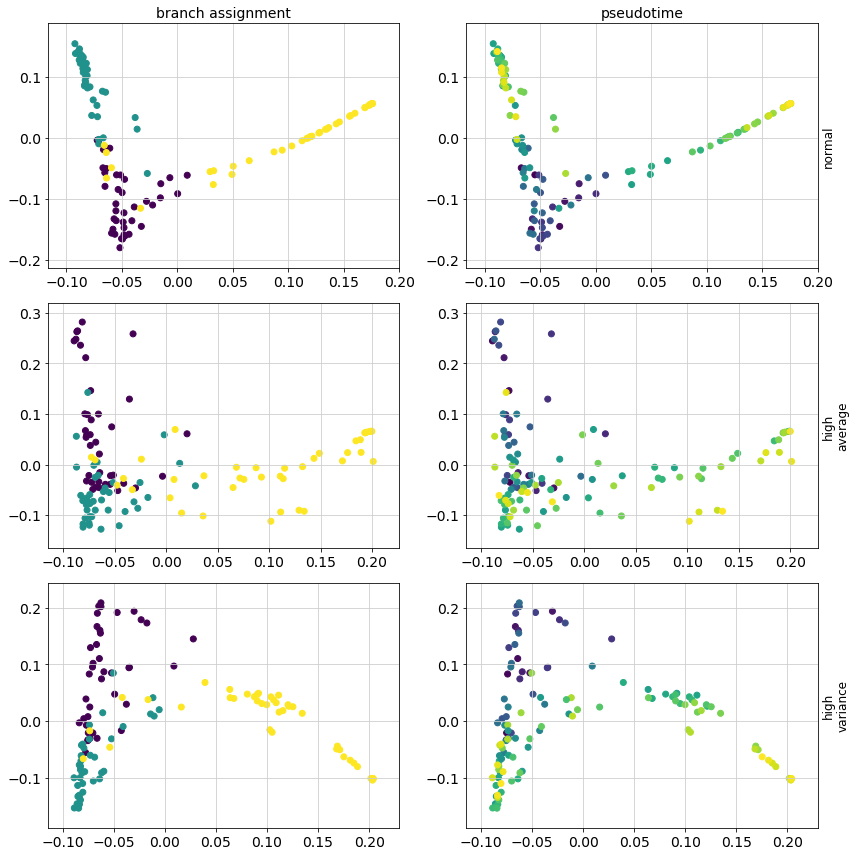

In [9]:
fig, ax = plt.subplots(ncols=2, nrows=3)
fig.set_size_inches(w=12, h=12)
ax[0][0].scatter(dm1[:, 0], dm1[:, 1], c=indices1)
ax[0][1].scatter(dm1[:, 0], dm1[:, 1], c=labs1)
ax[1][0].scatter(dm2[:, 0], dm2[:, 1], c=indices2)
ax[1][1].scatter(dm2[:, 0], dm2[:, 1], c=labs2)
ax[2][0].scatter(dm3[:, 0], dm3[:, 1], c=indices3)
ax[2][1].scatter(dm3[:, 0], dm3[:, 1], c=labs3)

ax[0][0].set_title("branch assignment")
ax[0][1].set_title("pseudotime")

ax[0][1].yaxis.set_label_position("right")
ax[0][1].set_ylabel("normal", rotation=90, size='large')
ax[1][1].yaxis.set_label_position("right")
ax[1][1].set_ylabel("high\naverage", rotation=90, size='large')
ax[2][1].yaxis.set_label_position("right")
ax[2][1].set_ylabel("high\nvariance", rotation=90, size='large')

fig.tight_layout()

plt.show()

The "progenitors" (dark blue) branch out to two different cell fates (left). Pseudotime flows from the progenitors (dark) to the fully differentiated cell fates (yellow) (all panels)

While the overall shape of the process is the same, the high $\alpha$ and $\beta$ values increase the variance of gene expression. This makes cells from different pseudotimes look similar by chance, and mixes them together. This obscures the overall signal (second row).

Choosing $\alpha$ and $\beta$ from distributions with realistic mean but high variance means that some genes are going to have very high variance while others will have very low. If one gene has high average expression in one branch _combined with_ high expression variance, it will make differences between the expression of other genes seem insignificant in comparison. This branch will be very clearly separated but will obscure the relationship between the other branches (third row).